# Klassifikation
Da mir lediglich Laptop-Lautsprecher und Laptop-Mikrofon zur verfügung stehen lassen sich leider keine gerichteten Audiosignale erzeugen und aufnehmen. Eine Objekterkennung wird daher vermutlich schwierig. 
Im folgenden versuche ich daher erst einmal das Echo in verschiedenen Räumen einzufangen und mit einem einfachen CNN zu erkennen in welchen Raum das Echo eingefangen wurde.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import pathlib
import numpy as np
import glob
import os
import tensorflow_io as tfio
from components.signal_generator import signal_generator,audio_interface 

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Daten-Pipeline erstellen

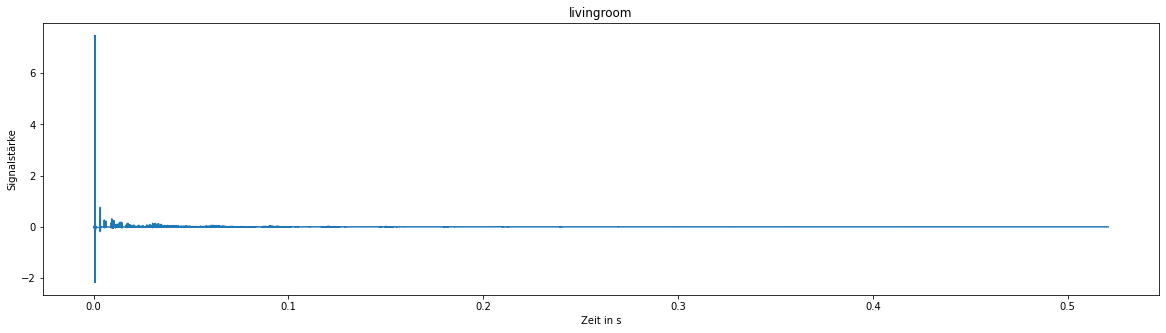

In [3]:
data_dir = pathlib.Path("components/data")
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])

def label_encoder(label):
    temp=[0]*len(CLASS_NAMES)
    for i,x in enumerate(CLASS_NAMES):
        if x==label:
            temp[i]=1
    return temp

def label_decoder(label):
    l=""
    for i,x in enumerate(label): 
        if x==1:
            l=CLASS_NAMES[i]
    return l
def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    spec={"/signal":tf.float64,"/rir":tf.float64}
    samples = tfio.v0.IOTensor.from_hdf5(file_path,spec=spec)("/rir").to_tensor()[:50000] #TODO
    return tf.reshape(samples,[50000,1]), label_encoder(label)


labeled_ds = list_ds.map(process_path,num_parallel_calls=AUTOTUNE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


BATCH_SIZE = 32


train_dataset = prepare_for_training(labeled_ds.take(int(len(list_ds)*0.6)))
test_dataset = prepare_for_training(labeled_ds.skip(int(len(list_ds)*0.6)))

for image_raw, label_text in labeled_ds.take(1):
    signal_generator(sr=96000).plot_signal(image_raw.numpy().reshape(50000),title=label_decoder(label_text))


In [4]:
for image, label in train_dataset.take(1):
    print(image.shape)
    #print("Image shape: ", image.numpy().shape)
    #print("Label: ", label.numpy())
    print("Label: ", label.numpy())


(32, 50000, 1)
Label:  [[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]]


## CNN-Architektur erstellen

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout
from tensorflow.keras import regularizers

model = Sequential([
    Conv1D(8, 3, padding='same', activation='relu', input_shape=(50000,1),name="inputlayer"),
    MaxPooling1D(),
    Conv1D(16, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(64, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(128, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(256, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    #Dropout(0.2),
    Conv1D(128, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Dropout(0.3),
    Conv1D(64, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.1)),
    Dropout(0.3),
    Dense(3, activation='softmax', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer (Conv1D)          (None, 50000, 8)          32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25000, 8)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25000, 16)         400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12500, 16)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12500, 32)         1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6250, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6250, 64)          6

In [6]:
model.compile(
        optimizer='adam',
        loss=['categorical_crossentropy'],
        metrics=['accuracy']
    )

In [ ]:
history=model.fit(train_dataset,epochs=10,validation_data=test_dataset,steps_per_epoch=30,validation_steps=10)

Epoch 1/10
30/30 [==============================] - 209s 7s/step - loss: 18.9363 - accuracy: 0.7229 - val_loss: 3.0445 - val_accuracy: 0.9844
Epoch 2/10
30/30 [==============================] - 198s 7s/step - loss: 1.0521 - accuracy: 0.9646 - val_loss: 0.2955 - val_accuracy: 0.9812
Epoch 3/10
30/30 [==============================] - 168s 6s/step - loss: 0.2355 - accuracy: 0.9781 - val_loss: 0.1299 - val_accuracy: 1.0000
Epoch 4/10
30/30 [==============================] - 169s 6s/step - loss: 0.1105 - accuracy: 0.9948 - val_loss: 0.0778 - val_accuracy: 0.9969
Epoch 5/10
30/30 [==============================] - 161s 5s/step - loss: 0.1115 - accuracy: 0.9885 - val_loss: 0.1199 - val_accuracy: 0.9844
Epoch 6/10
30/30 [==============================] - 189s 6s/step - loss: 0.0952 - accuracy: 0.9948 - val_loss: 0.1118 - val_accuracy: 0.9844
Epoch 7/10
30/30 [==============================] - 203s 7s/step - loss: 0.0890 - accuracy: 0.9927 - val_loss: 0.0629 - val_accuracy: 1.0000
Epoch 8/10
3

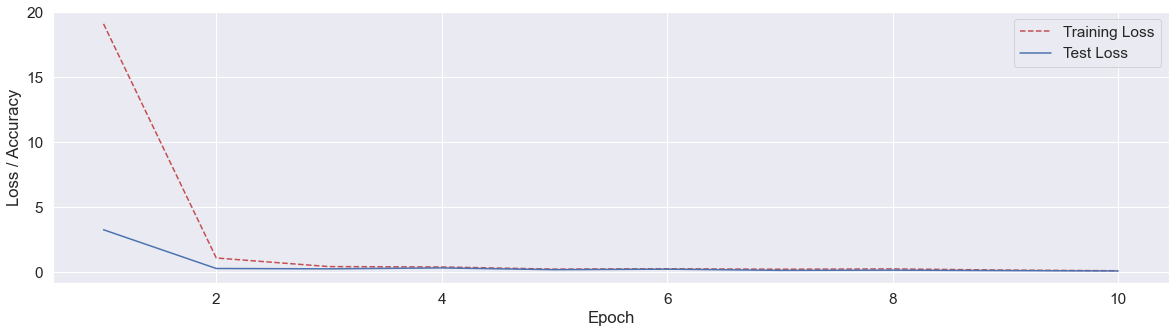

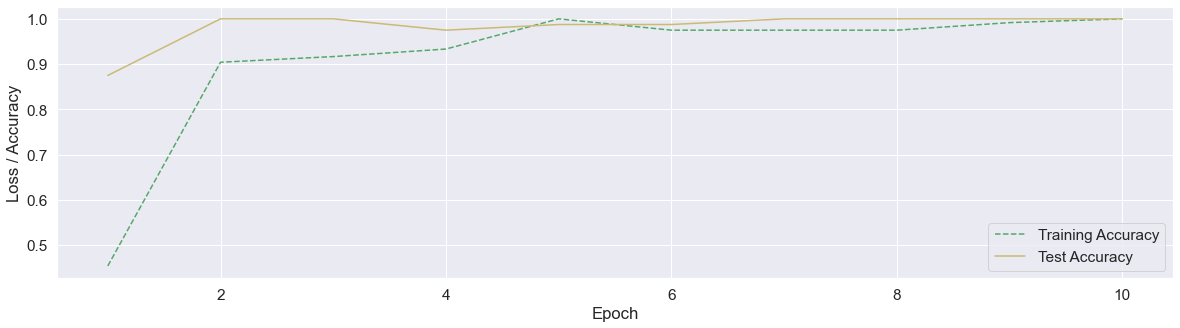

In [65]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)


# Visualize loss history
plt.figure(figsize=(20,5))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss','training_accuracy','test_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.show();

plt.figure(figsize=(20,5))
plt.plot(epoch_count, training_accuracy, 'g--')
plt.plot(epoch_count, test_accuracy, 'y-')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.show();

In [66]:
true=[]
pred=[]
for images, labels in test_dataset.take(30):
    for index,image in enumerate(images):
        pred_temp=model.predict(tf.reshape(image,(1,50000,1)))[0]
        pred_temp=[1 if x ==max(pred_temp) else 0 for x in pred_temp]
        true_temp=(labels[index].numpy())
        true.append(np.argmax(true_temp))
        pred.append(np.argmax(pred_temp))


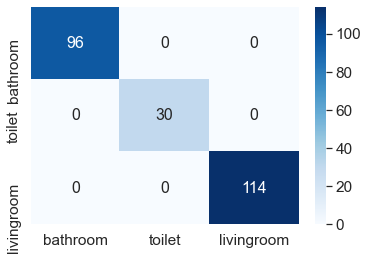

In [67]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(tf.math.confusion_matrix(true,pred).numpy(), CLASS_NAMES, CLASS_NAMES)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="d") # font size

plt.show()

## Live Testing

In [275]:
from PIL import Image
from matplotlib.pyplot import imshow
import os
import glob
import time
import sounddevice as sd
import numpy as np
import time
import librosa

def generate_new_echo(fs=96000,duration=0.1,f=25000):
    time.sleep(1)
    sine = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    samples=np.concatenate((sine, [0]*int(fs*duration)*2), axis=None)
    
    for i in range(2):
        samples=np.concatenate((samples, sine), axis=None)
        samples=np.concatenate((samples, [0]*int(fs*duration*2)), axis=None)


    rec=sd.playrec(samples,fs,channels=1)
    rec=rec.reshape((samples.shape[0]))[60050:87000]
    time.sleep(1)
    return rec


    
def img_from_audio(rec):
    
    D=np.abs(librosa.stft(rec,n_fft=2048,hop_length=64))
    DB=librosa.amplitude_to_db(D,ref=np.max)
    
    
    img=np.interp(DB[250:600,:400], (DB[250:600,:400].min(), DB[250:600,:400].max()), (0, 255))
    img = Image.fromarray(np.uint8(img) , 'L')
    img.save("temp.png")
    return img

wohnzimmer


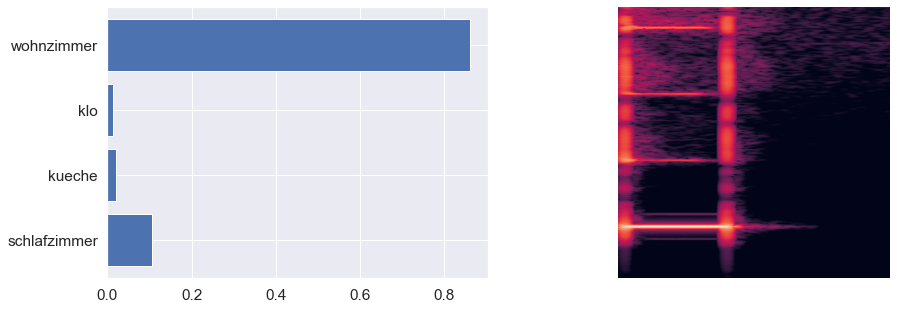

In [396]:
img=img_from_audio(generate_new_echo())

#print(CLASS_NAMES)
img = tf.io.read_file("temp.png")
#img = tf.io.read_file("data/schlafzimmer/100.png")
img = decode_img(img)
print(CLASS_NAMES[np.argmax(model.predict(tf.reshape(img,(1,400,400,1))))])

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[1].imshow(img.numpy().reshape(400,400))
axs[1].set_axis_off()
axs[0].barh([0,1,2,3],model.predict(tf.reshape(img,(1,400,400,1)))[0], align='center')
axs[0].set_yticks([0,1,2,3])
axs[0].set_yticklabels(CLASS_NAMES)
plt.show()

## Fazit
Die ersten Ergebnisse sind sehr zufriedenstellend. Beim Live-Testing des trainierten Netzes konnte ich feststellen, das es dem CNN schwer fällt, die Küche richtig zu erkennen. 

Nach weiteren Experimenten stellte ich fest, dass die KI fast immer den richtigen Raum erkennt, vorrausgesetzt der Laptop steht nahe der Stelle stellt, an der die Trainingsdaten erzeugt wurden.

Dies ist im nachhinein auch nicht verwunderlich, da ich den Laptop beim aufzeichnen der Trainingsdaten nie vom Fleck bewegt habe. Ich habe lediglich versucht möglichst verschiedene Szenarien zu erzeugen (Musik,Spülmaschine,Stille,Fenster auf usw.)

Ein spannende TODOS wäre nun mehr Trainingsdaten mit noch größerer Varianz zu erzeugen. Diesmal aber nicht nur Varianz in Umgebungsgeräuschen sondern auch Varianz der Aufnahme-Position im Zimmer. Weiter wäre es spannend zu erfahren, welche Auswirkungen eine höhere Sample Rate hätte!